**Este é um trabalho realizado por alunos da UFPR para a matéria de graduação de Machine Learning. A database utilizada foi a Telco Customer Churn, disponível em https://www.kaggle.com/datasets/blastchar/telco-customer-churn.**

**Nosso objetivo é criar um modelo de machine learning que consiga prever se um cliente irá ou não dar o Churn utilizando os dados fornecidos pela database.**

**Para este trabalho, utilizamos a validação hold-out com 70% dos dados para treino. Além disso, como será visto durante o código, para filtragem de variáveis foi utilizada a regressão lasso, com a qual fizemos um grid-search e também comparamos resultados para diferentes alphas.**

**Trouxemos também algumas reflexões e análises sobre regras de negócios, análise de covariância, balanceamento e transformação de dados.**

**Os modelos de treinamento utilizados foram KNN, Naive Bayes, Random Forest e xgboost com parâmetros determinados com grid search.**

**Tendo em vista a natureza do trabalho, nosso objetivo não é fazer um algoritmo estado de arte, mas analisar e comparar resultados, trazendo reflexões tanto para nós, autores, quanto para os futuros leitores.**

In [ ]:
import sklearn
import pandas  as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV


In [ ]:
files.upload()

**LENDO O ARQUIVO CSV**

In [ ]:
dataset = pd.read_csv('dataset.csv')
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**NO PRIMEIRO COMANDO, ESTAMOS FAZENDO A CONTAGEM DE CAMPOS TOTAIS, CAMPOS NULOS E OBSERVANDO A TIPAGEM DE CADA FEATURE.**

**NO SEGUNDO, PODEMOS OBSERVAR, ALÉM DA CONTAGEM DOS CAMPOS, A MÉDIA, DESVIO PADRÃO, O MÍNIMO E O MÁXIMO DAS FEATURES NUMÉRICAS**

In [ ]:
## printa as informações do dataset. Nosso objetivo é saber o tipo das variáveis e verrificar se é necessária alguma alterção
dataset.info()

## printa a quantidade de linhas preenchidas, média, desvio padrão e menor valor
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


**Neste primeiro treino vamos fazer a validação hold-out, que consiste em dividir base de dados entre base de treino e base de validação. Nossa escolha de proporção foi de 70% dos dados para treinamento e 30% dos dados para validação.**

In [ ]:
base_treino = dataset.sample(frac=0.7,random_state=42) # Pegando 70% da base aleatóriamente para ser treino.
print(base_treino.shape)

index_fora_do_treino = dataset.index.difference(base_treino.index) # Pegando os indexes que não estão na base

base_val = dataset.iloc[index_fora_do_treino]
print(base_val.shape)

(4930, 21)
(2113, 21)


**Agora nós temos a base de treino com 4930 linha e a base de validação com 2113, totalizando os 7043 clientes únicos.**

Dividindo as features da resposta

In [ ]:
X_treino = base_treino.drop(columns='Churn')
Y_treino = base_treino['Churn']
X_val = base_val.drop(columns='Churn')
Y_val = base_val.Churn


Agora, vamos verificar o balanceamento do dataset:

In [ ]:
Churn = base_treino[base_treino.Churn == 'Yes'].customerID.count()
NoChurn = base_treino[base_treino.Churn == 'No'].customerID.count()

ChurnPercentage = Churn/(Churn + NoChurn)

print(f'Churn percentage = {ChurnPercentage}')

Churn percentage = 0.2695740365111562


Apenas 26,9% dos clientes deram Churn neste dataset. Para evitar problemas com o treinamento, realizaremos um oversampling para que a classe minoritária alcance 50% do dataset. (número alcançado a partir de testes manuais)

Como nossos dados estão desbalanceados, utilizaremos a biblioteca imblearn para realizar um oversampling

In [ ]:
ros = RandomOverSampler(sampling_strategy=1,random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_treino, Y_treino)

Vamos verificar o tamanho do dataset e se o oversample foi realizado corretamente.

In [ ]:
Resample_df = X_resampled
Resample_df['Churn'] = y_resampled



In [ ]:
Churn = Resample_df[Resample_df.Churn == 'Yes'].customerID.count()
NoChurn = Resample_df[Resample_df.Churn == 'No'].customerID.count()

ChurnPercentage = Churn/(Churn + NoChurn)
print(f'Churn percentage = {ChurnPercentage}')

Churn percentage = 0.5


**Agora, com um Churn rate de 50%, vamos tratar os dados de treino. Lembrando que tudo que for feito nos dados de treino, também deve ser feito nos dados de validação.**





# **DADOS DE TREINO**

In [ ]:
X_treino = X_resampled
Y_treino = y_resampled

**Primeiramente, analisaremos os dados de treino utilizando os comandos info e describe.**

In [ ]:
X_treino.info()
X_treino.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7202 entries, 0 to 7201
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7202 non-null   object 
 1   gender            7202 non-null   object 
 2   SeniorCitizen     7202 non-null   int64  
 3   Partner           7202 non-null   object 
 4   Dependents        7202 non-null   object 
 5   tenure            7202 non-null   int64  
 6   PhoneService      7202 non-null   object 
 7   MultipleLines     7202 non-null   object 
 8   InternetService   7202 non-null   object 
 9   OnlineSecurity    7202 non-null   object 
 10  OnlineBackup      7202 non-null   object 
 11  DeviceProtection  7202 non-null   object 
 12  TechSupport       7202 non-null   object 
 13  StreamingTV       7202 non-null   object 
 14  StreamingMovies   7202 non-null   object 
 15  Contract          7202 non-null   object 
 16  PaperlessBilling  7202 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7202.000000,7202.000000,7202.000000
mean,0.186893,27.792558,67.951770
std,0.389852,24.006954,28.538741
min,0.000000,0.000000,18.700000
25%,0.000000,5.000000,45.750000
50%,0.000000,22.000000,74.500000
75%,0.000000,49.000000,90.950000
max,1.000000,72.000000,118.750000


**Note que a feature "Total Charges" está tipada como objeto. Portanto, faremos uma conversão para float.**

In [ ]:
#Transforma a coluna TotalCharges em numérica, o parâmetro coerce força com que a transformação seja feita, ignorando os erros.
X_treino["TotalCharges"] = pd.to_numeric(X_treino.TotalCharges, errors='coerce')



**Tendo em vista que mudamos a tipagem da coluna TotalCharges de object para float utilizando o parâmetro "coerce", que força essa mudança, é interessante analisarmos novamente se esta coluna tem algum dado NaN (not a number), que poderá influenciar futuramente a nossa modelagem.**




In [ ]:
X_treino[X_treino.TotalCharges.isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
765,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
1413,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No
1691,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3828,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4143,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
4312,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No


Note que exatamente os mesmos clientes que estão com dados faltantes no campo TotalCharges são os únicos com tenure igual a zero.

In [ ]:
X_treino[X_treino.tenure == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
765,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
1413,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No
1691,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3828,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4143,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
4312,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No


**Encontramos seis clientes onde a feature "TotalCharges" está faltante. Note que o comando describe não captou estes dados. Isso se deve ao fato de termos strings com um espaço no campo, fazendo com que o describe entendesse aquilo como um campo preenchido. Mas quando trocamos para float e utilizamos o comando "coerce" os campos nulos são evidenciados**


**Para resolver o problema dos campos nulos, vamos fazer uma análise dos dados obtidos.**

**No banco de dados, nós temos três colunas que podem nos ajudar a entender estes dados faltantes. A coluna tenure, que é o período em que o cliente consome (ou consumiu) o nosso produto, em meses; a coluna monthly charges, que corresponde a conta mensal que deve ser paga pelo cliente pelo serviço e finalmente a coluna totalcharges, que corresponde ao montante total pago pelo cliente até o momento.**

**Portanto, podemos supor que a coluna totalcharges possa ser descrita da seguinte maneira:**



>>>TotalCharges = (MonthlyCharges) x (Tenure)

**Porém, em algumas linhas podemos ver sutis diferenças entre o valor de TotalCharges calculado desta maneira e o real. Porém, para o caso de Tenure igual a zero, ou seja, o cliente ainda não completou um mês, podemos entender que a primeira fatura ainda não foi cobrada e, portanto, TotalCharges é igual a zero neste momento. Exatamente o que acontece nas linhas com dados faltantes, todas elas tem tenure igual a zero. Portanto, podemos fazer esta interpretação dos dados**







In [ ]:
X_treino['TotalCharges'].replace(np.NaN, 0, inplace=True)
X_treino[X_treino.TotalCharges.isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


**Agora, sem dados faltantes, podemos continuar a nossa modelagem. O primeiro passo será remover a coluna de Id dos clientes para evitar dados vazados.**


In [ ]:
X_treino.head()
X_treino.drop('customerID', axis=1, inplace=True)

**Transformando os dados de classificação em numéricos:**

In [ ]:
for i in X_treino:

  if X_treino[i].dtypes=='object':
    print(f'{i}: {X_treino[i].unique()}' )

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'Yes' 'No']
InternetService: ['DSL' 'No' 'Fiber optic']
OnlineSecurity: ['No' 'No internet service' 'Yes']
OnlineBackup: ['No' 'No internet service' 'Yes']
DeviceProtection: ['No' 'No internet service' 'Yes']
TechSupport: ['No' 'No internet service' 'Yes']
StreamingTV: ['No' 'No internet service' 'Yes']
StreamingMovies: ['No' 'No internet service' 'Yes']
Contract: ['Month-to-month' 'Two year' 'One year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Bank transfer (automatic)' 'Mailed check'
 'Credit card (automatic)']
Churn: ['Yes' 'No']


In [ ]:
#Filtrando respostas com mesmo sentido
X_treino.replace('No phone service', 'No', inplace=True)
X_treino.replace('No internet service', 'No', inplace=True)

#Transformando os dados de classificação em numéricos
X_treino_num = X_treino.replace('No', 0)
X_treino_num.replace('Yes', 1, inplace=True)
X_treino_num['gender'].replace('Female', 0, inplace=True)
X_treino_num['gender'].replace('Male', 1, inplace=True)
X_treino_num.replace('DSL', 1, inplace=True)
X_treino_num.replace('Fiber optic', 2, inplace=True)
X_treino_num.replace('Month-to-month', 0, inplace=True)
X_treino_num.replace('Two year',  2, inplace=True)
X_treino_num.replace('One year', 1, inplace=True)
X_treino_num.replace('Electronic check', 0, inplace=True)
X_treino_num.replace('Bank transfer (automatic)', 1, inplace=True)
X_treino_num.replace('Mailed check', 2, inplace=True)
X_treino_num.replace('Credit card (automatic)', 3, inplace=True)

Agora podemos olhar para a correlação e variância das features

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text major ticklabel objects>)

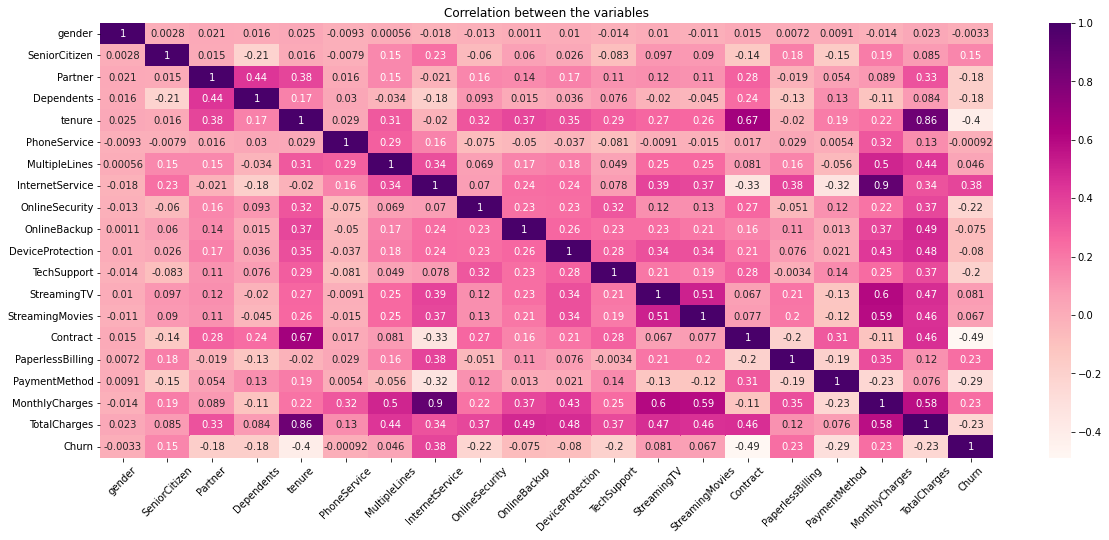

In [ ]:
plt.subplots(figsize=(20,8))

df_plot = X_treino_num

df_plot['Churn'] = np.where(Y_treino == 'No', 0, 1)
features_correlation=df_plot.corr()
sb.heatmap(features_correlation,annot=True,cmap='RdPu')
plt.title('Correlation between the variables')
plt.xticks(rotation=45)


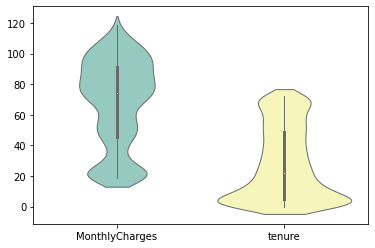

In [ ]:
sb.violinplot(data=X_treino_num[['MonthlyCharges', 'tenure']], palette="Set3", bw=.2, cut=1, linewidth=1)


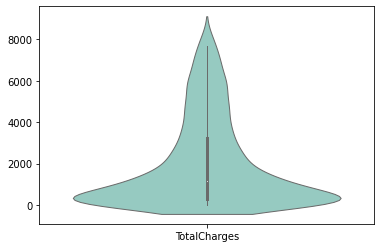

In [ ]:
sb.violinplot(data=X_treino_num[['TotalCharges']], palette="Set3", bw=.2, cut=1, linewidth=1)

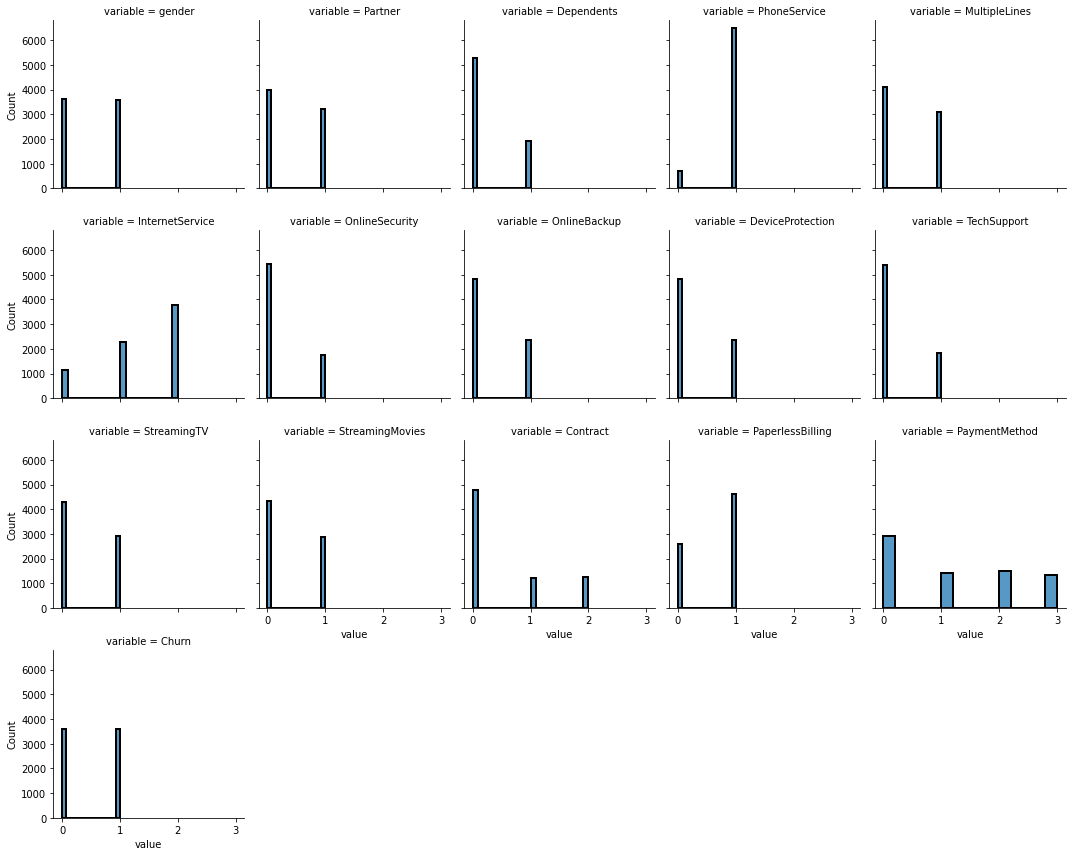

In [ ]:
plot_dataframe = X_treino_num.drop(columns=['TotalCharges', 'MonthlyCharges', 'tenure'])
Y_treino = np.where(Y_treino == 'No', 0, 1)

df = pd.melt(plot_dataframe, plot_dataframe.columns[1], plot_dataframe.columns[:])

g = sb.FacetGrid(df, col="variable", col_wrap=5)
g.map(sb.histplot, "value", linewidth=2)

In [ ]:
X_treino_num.drop(columns='Churn', inplace=True)

**Normalizando os dados para evitar problemas de escala no modelo**

In [ ]:
def normalizar(lista):
    return (lista - np.min(lista))/(np.max(lista) - np.min(lista))

X_train_norm = X_treino_num.apply(lambda x: normalizar(x), axis = 0)
X_train_norm.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0.0,0.0,1.0,0.0,0.013889,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.060970,0.002856
1,1.0,0.0,0.0,0.0,0.569444,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.333333,0.065467,0.114735
2,0.0,0.0,1.0,1.0,0.722222,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.666667,0.006497,0.118794
3,0.0,0.0,0.0,0.0,0.013889,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.576212,0.008791
4,1.0,0.0,0.0,0.0,0.930556,1.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.318341,0.375380


USANDO REGRESSÃO LASSO PARA FILTRAR AS VARIÁVEIS NORMALIZADAS

In [ ]:
from sklearn import linear_model

coef_matrix = []
search_space = {
    "alpha" : [0.00001, 0.00005, 0.0001,0.0005, 0.001,0.004, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.15]
}
for i in range(len(search_space["alpha"])):
  clf = linear_model.Lasso(alpha=search_space["alpha"][i])
  clf.fit(X_train_norm, Y_treino)
  coef_matrix.append(clf.coef_)
  print(coef_matrix)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.005e+00, tolerance: 1.801e-01
  model = cd_fast.enet_coordinate_descent(


[array([ 0.00857262,  0.035808  , -0.01316677, -0.0074442 , -0.26104439,
       -0.05972415,  0.05635211,  0.45317898, -0.09476129,  0.00625109,
       -0.00382449, -0.07022174,  0.06752704,  0.04503602, -0.20627283,
        0.05909034, -0.08211555, -0.14305826, -0.19228351])]
[array([ 0.00857262,  0.035808  , -0.01316677, -0.0074442 , -0.26104439,
       -0.05972415,  0.05635211,  0.45317898, -0.09476129,  0.00625109,
       -0.00382449, -0.07022174,  0.06752704,  0.04503602, -0.20627283,
        0.05909034, -0.08211555, -0.14305826, -0.19228351]), array([ 0.00835389,  0.0356342 , -0.01300872, -0.00738495, -0.26171799,
       -0.08782916,  0.04880132,  0.38116158, -0.10187148, -0.00071116,
       -0.01082308, -0.07737432,  0.05296492,  0.03062216, -0.20643657,
        0.05916896, -0.08210943, -0.        , -0.1903328 ])]
[array([ 0.00857262,  0.035808  , -0.01316677, -0.0074442 , -0.26104439,
       -0.05972415,  0.05635211,  0.45317898, -0.09476129,  0.00625109,
       -0.00382449, -0

Para entender melhor, vamos fazer um gráfico dessa matriz de coeficientes

In [ ]:
alpha_index = []
for i in range(len(search_space['alpha'])):
  alpha_index.append(f'alpha{i}')
alphas = pd.DataFrame(search_space['alpha'], index=alpha_index)

coef_dataframe = pd.DataFrame(coef_matrix, index=search_space['alpha'])


In [ ]:
coef_dataframe

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0.00001,0.008573,0.035808,-0.013167,-0.007444,-0.261044,-0.059724,0.056352,0.453179,-0.094761,0.006251,-0.003824,-0.070222,0.067527,0.045036,-0.206273,0.059090,-0.082116,-0.143058,-0.192284
0.00005,0.008354,0.035634,-0.013009,-0.007385,-0.261718,-0.087829,0.048801,0.381162,-0.101871,-0.000711,-0.010823,-0.077374,0.052965,0.030622,-0.206437,0.059169,-0.082109,-0.000000,-0.190333
0.00010,0.008126,0.035454,-0.012914,-0.007341,-0.263448,-0.087273,0.048354,0.380262,-0.101879,-0.000679,-0.010675,-0.077339,0.052613,0.030278,-0.206636,0.059138,-0.082113,0.000000,-0.186237
0.00050,0.006292,0.034014,-0.012125,-0.006989,-0.278088,-0.082928,0.044752,0.372877,-0.101984,-0.000493,-0.009544,-0.077109,0.049738,0.027448,-0.208203,0.058892,-0.082162,0.000000,-0.152169
0.00100,0.004004,0.032213,-0.011154,-0.006549,-0.296023,-0.077451,0.040262,0.363732,-0.102094,-0.000228,-0.008106,-0.076799,0.046173,0.023946,-0.210174,0.058585,-0.082214,0.000000,-0.110179
0.00400,0.000000,0.021592,-0.005190,-0.004399,-0.320816,-0.036313,0.016490,0.332375,-0.096784,-0.000000,-0.000000,-0.068610,0.031400,0.009992,-0.225909,0.056366,-0.079859,0.000000,-0.000000
0.00500,0.000000,0.018060,-0.003045,-0.003818,-0.307172,-0.020689,0.009426,0.328500,-0.093328,-0.000000,-0.000000,-0.063985,0.028505,0.007480,-0.231920,0.055491,-0.078285,0.000000,-0.000000
0.01000,0.000000,0.000000,-0.000000,-0.000000,-0.248512,-0.000000,0.000000,0.309688,-0.078449,-0.000000,-0.000000,-0.043516,0.008216,0.000000,-0.255382,0.049018,-0.068202,0.000000,-0.000000
0.02000,0.000000,0.000000,-0.000000,-0.000000,-0.160459,-0.000000,0.000000,0.244350,-0.048067,-0.000000,-0.000000,-0.007778,0.000000,0.000000,-0.293417,0.027804,-0.039715,0.000000,-0.000000
0.03000,0.000000,0.000000,-0.000000,-0.000000,-0.072733,-0.000000,0.000000,0.180296,-0.011661,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.325628,0.006045,-0.007735,0.000000,-0.000000


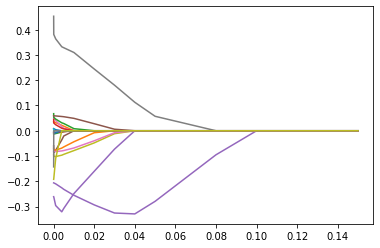

In [ ]:
plt.plot(coef_dataframe)

In [ ]:
coef_dataframe.loc[0.03]


0     0.000000
1     0.000000
2    -0.000000
3    -0.000000
4    -0.072733
5    -0.000000
6     0.000000
7     0.180296
8    -0.011661
9    -0.000000
10   -0.000000
11   -0.000000
12    0.000000
13    0.000000
14   -0.325628
15    0.006045
16   -0.007735
17    0.000000
18   -0.000000
Name: 0.03, dtype: float64

In [ ]:
coef_dataframe.loc[0.04]

0     0.000000
1     0.000000
2    -0.000000
3    -0.000000
4    -0.000000
5    -0.000000
6     0.000000
7     0.112583
8    -0.000000
9    -0.000000
10   -0.000000
11   -0.000000
12    0.000000
13    0.000000
14   -0.329167
15    0.000000
16   -0.000000
17    0.000000
18   -0.000000
Name: 0.04, dtype: float64

Para alpha = 0.03 o filtro da regressão forneceu 3 betas diferentes de zero, para alpha = 0.02 temos 7 features e para alpha = 0.01 temos 9 features. Assim, acreditamos que esse seja um bom ponto de corte para realizar os testes, tendo em vista que para valores maiores temos um número muito pequeno de betas e não queremos fazer previsões baseadas em somente uma feature.

TREINAMENTO COM TODAS AS FEATURES

Vamos testar os modelos de classificação kNN, Naive Bayes, Random Forest e xgboost

Tratar os dados de validação pra testar o modelo

In [ ]:
## Transformando os valores da coluna TotalCharges em numéricos
X_val["TotalCharges"] = pd.to_numeric(X_val.TotalCharges, errors='coerce')
X_val['TotalCharges'].replace(np.NaN, 0, inplace=True)

##Tirando a coluna customerID
X_val.drop(columns='customerID', inplace=True)

## Transformando os dados de classificação em numéricos
X_val.replace('No phone service', 'No', inplace=True)
X_val.replace('No internet service', 'No', inplace=True)
X_val.replace('No', 0, inplace=True)
X_val.replace('Yes', 1, inplace=True)
X_val.replace('Female', 0, inplace=True)
X_val.replace('Male', 1, inplace=True)
X_val.replace('DSL', 1, inplace=True)
X_val.replace('Fiber optic', 2, inplace=True)
X_val.replace('Month-to-month', 0, inplace=True)
X_val.replace('Two year',  2, inplace=True)
X_val.replace('One year', 1, inplace=True)
X_val.replace('Electronic check', 0, inplace=True)
X_val.replace('Bank transfer (automatic)', 1, inplace=True)
X_val.replace('Mailed check', 2, inplace=True)
X_val.replace('Credit card (automatic)', 3, inplace=True)

## Escalando o dataset
X_val_norm = X_val.apply(lambda x: normalizar(x), axis = 0)

## Transformando a resposta de classificação em numérica
Y_val.replace('Yes', 1, inplace=True)
Y_val.replace('No', 0, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


TREINO COM KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# definindo a quantidade de vizinhos
neigh = KNeighborsClassifier(n_neighbors=3)

param_grid = {'n_neighbors': np.arange(2,30,1)}
grid_search = GridSearchCV(neigh, param_grid, scoring='recall')
grid_result = grid_search.fit(X_train_norm, Y_treino)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')



Best result: 0.8881037139775003 for {'n_neighbors': 3}


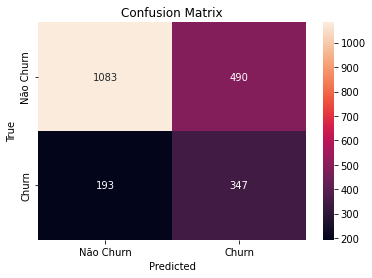

In [ ]:

## Ajustando os dados que vão para treino
neigh.fit(X_train_norm, Y_treino)
predict = list(neigh.predict(X_val_norm))

## Fazendo a matriz confusão
confusion_matrix = sklearn.metrics.confusion_matrix(Y_val, predict)
ax= plt.subplot()
sb.heatmap(confusion_matrix, xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'], annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted');ax.set_ylabel('True');
ax.set_title('Confusion Matrix');

Validação

In [ ]:
from sklearn.metrics import recall_score
recall_score(Y_val, predict)

0.6425925925925926

Treino

In [ ]:
predict = neigh.predict(X_train_norm)
recall_score(Y_treino, predict)

0.9688975284643154

TREINO UTILIZANDO AS 6 VARIÁVEIS FILTRADOS NA REGRESSÃO LASSO COM ALPHA = 0,03



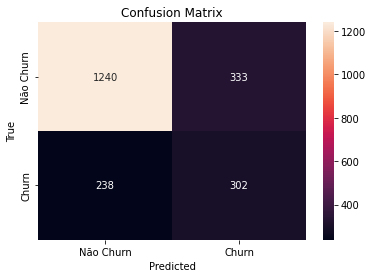

In [ ]:
## Dropando as colunas que ficaram com Beta = 0
X_train_norm_alpha_um = X_train_norm[['tenure', 'InternetService', 'OnlineSecurity', 'Contract', 'PaperlessBilling', 'PaymentMethod']]
X_val_norm_alpha_um = X_val_norm[['tenure', 'InternetService', 'OnlineSecurity', 'Contract', 'PaperlessBilling', 'PaymentMethod']]

## Ajustando os dados que vão para treino
neigh.fit(X_train_norm_alpha_um, Y_treino)
predict = list(neigh.predict(X_val_norm_alpha_um))

## Fazendo a matriz confusão
confusion_matrix = sklearn.metrics.confusion_matrix(Y_val, predict)
ax= plt.subplot()
sb.heatmap(confusion_matrix, xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'], annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted');ax.set_ylabel('True');
ax.set_title('Confusion Matrix');

Validação

In [ ]:
recall_score(Y_val, predict)

0.5592592592592592

Treino

In [ ]:
predict = neigh.predict(X_train_norm_alpha_um)
recall_score(Y_treino, predict)

0.7839489030824771

TREINO UTILIZANDO AS 2 VARIÁVEIS FILTRADOS NA REGRESSÃO LASSO COM ALPHA = 0,04



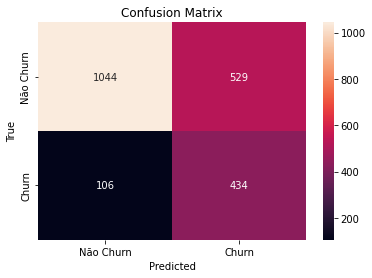

In [ ]:
X_train_norm_alpha_dois = X_train_norm[['InternetService', 'Contract']]
X_val_norm_alpha_dois = X_val_norm[[ 'InternetService', 'Contract']]

## Ajustando os dados que vão para treino
neigh.fit(X_train_norm_alpha_dois, Y_treino)
predict = list(neigh.predict(X_val_norm_alpha_dois))

## Fazendo a matriz confusão
confusion_matrix = sklearn.metrics.confusion_matrix(Y_val, predict)
ax= plt.subplot()
sb.heatmap(confusion_matrix, xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'], annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted');ax.set_ylabel('True');
ax.set_title('Confusion Matrix');




Validação

In [ ]:
recall_score(Y_val, predict)

0.8037037037037037

Treino

In [ ]:
predict = neigh.predict(X_train_norm_alpha_dois)
recall_score(Y_treino, predict)

0.8500416550958068

TREINO COM NAIVE BAYES

Com todas as variáveis

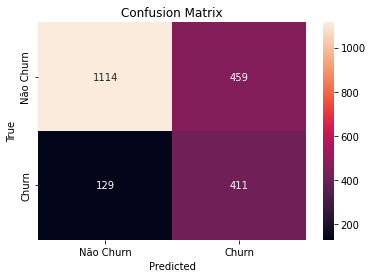

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train_norm, Y_treino)
predict = clf.predict(X_val_norm)

##fazendo a matriz de confusão
confusion_matrix = sklearn.metrics.confusion_matrix(Y_val, predict)

ax= plt.subplot()
sb.heatmap(confusion_matrix, xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'], annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted');ax.set_ylabel('True');
ax.set_title('Confusion Matrix');

In [ ]:
recall_score(Y_val, predict)

0.7611111111111111

Com 6 variáveis

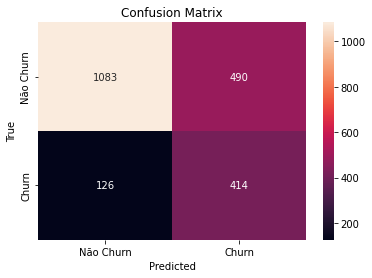

In [ ]:

clf = MultinomialNB()
clf.fit(X_train_norm_alpha_um, Y_treino)
predict = clf.predict(X_val_norm_alpha_um)

##fazendo a matriz de
confusion_matrix = sklearn.metrics.confusion_matrix(Y_val, predict)

ax= plt.subplot()
sb.heatmap(confusion_matrix, xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'], annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted');ax.set_ylabel('True');
ax.set_title('Confusion Matrix');

In [ ]:
recall_score(Y_val, predict)

0.7666666666666667

Com 2 variáveis

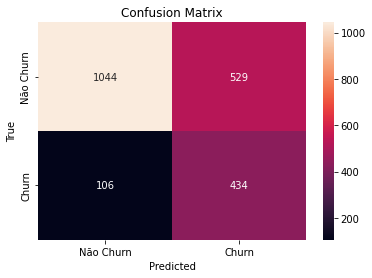

In [ ]:

clf = MultinomialNB()
clf.fit(X_train_norm_alpha_dois, Y_treino)
predict = clf.predict(X_val_norm_alpha_dois)

##fazendo a matriz de confusão
confusion_matrix = sklearn.metrics.confusion_matrix(Y_val, predict)

ax= plt.subplot()
sb.heatmap(confusion_matrix, xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'], annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted');ax.set_ylabel('True');
ax.set_title('Confusion Matrix');

In [ ]:
recall_score(Y_val, predict)

0.8037037037037037

TREINO COM RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 1200)
param_grid = {'n_estimators': np.arange(500,2000,100)}
grid_search = GridSearchCV(clf, param_grid, scoring='recall')
grid_result = grid_search.fit(X_train_norm, Y_treino)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')





Best result: 0.9689120049314225 for {'n_estimators': 1800}


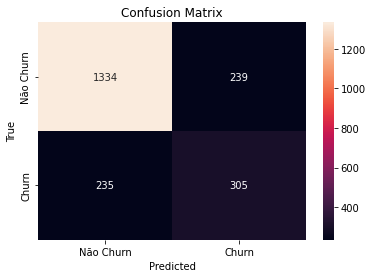

In [ ]:
clf = RandomForestClassifier(n_estimators = 1200)

clf.fit(X_train_norm, Y_treino)

predict = clf.predict(X_val_norm)

##fazendo a matriz de confusão
confusion_matrix = sklearn.metrics.confusion_matrix(Y_val, predict)

ax= plt.subplot()
sb.heatmap(confusion_matrix, xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'], annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted');ax.set_ylabel('True');
ax.set_title('Confusion Matrix');

Validação

In [ ]:
recall_score(Y_val, predict)

0.5648148148148148

Treino

In [ ]:
predict = clf.predict(X_train_norm)
recall_score(Y_treino, predict)

0.9986114968064427

Com 6 variáveis

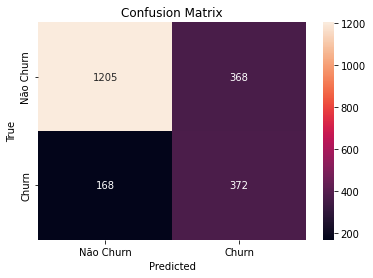

In [ ]:

clf = RandomForestClassifier(n_estimators = 900)
clf.fit(X_train_norm_alpha_um, Y_treino)
predict = clf.predict(X_val_norm_alpha_um)

##fazendo a matriz de confusão
confusion_matrix = sklearn.metrics.confusion_matrix(Y_val, predict)

ax= plt.subplot()
sb.heatmap(confusion_matrix, xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'], annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted');ax.set_ylabel('True');
ax.set_title('Confusion Matrix');




Validação

In [ ]:
recall_score(Y_val, predict)

0.6888888888888889

Treino

In [ ]:
predict = clf.predict(X_train_norm_alpha_um)
recall_score(Y_treino, predict)

0.9619550124965287

Com 2 variáveis

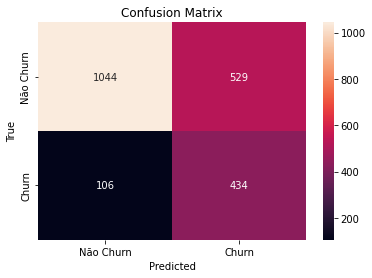

In [ ]:

clf = RandomForestClassifier(n_estimators = 900)
clf.fit(X_train_norm_alpha_dois, Y_treino)
predict = clf.predict(X_val_norm_alpha_dois)

##fazendo a matriz de confusão
confusion_matrix = sklearn.metrics.confusion_matrix(Y_val, predict)

ax= plt.subplot()
sb.heatmap(confusion_matrix, xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'], annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted');ax.set_ylabel('True');
ax.set_title('Confusion Matrix');




Validação

In [ ]:
recall_score(Y_val, predict)

0.8037037037037037

Treino


In [ ]:
predict = clf.predict(X_train_norm_alpha_dois)
recall_score(Y_treino, predict)

0.8500416550958068

TREINO XGBOOST COM TODAS AS VARIÁVEIS

In [ ]:



xgb = XGBClassifier()

# parameter to be searched
param_grid = {'learning_rate': [0.0001, 0.01, 0.1, 1]}

# find the best parameter
grid_search = GridSearchCV(xgb, param_grid, scoring='recall')
grid_result = grid_search.fit(X_train_norm, Y_treino)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')


In [ ]:

# parameter to be searched
param_grid = { 'gama': np.arange(0.0,20.0,0.05)}

# find the best parameter
grid_search = GridSearchCV(xgb, param_grid, scoring='recall')
grid_result = grid_search.fit(X_train_norm, Y_treino)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

In [ ]:

# parameter to be searched
param_grid = {'max_depth': range(1,8,1),
              'min_child_weight': np.arange(0.0001, 0.5, 0.01)}

# find the best parameter
grid_search = GridSearchCV(xgb, param_grid, scoring='recall')
grid_result = grid_search.fit(X_train_norm, Y_treino)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

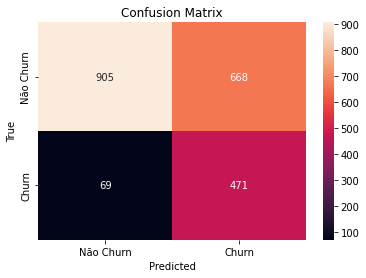

In [ ]:


xgb = XGBClassifier(learning_rate=0.0001, n_estimators=25, max_depth=1, min_child_weight=0.0001, gamma=0)
xgb.fit(X_train_norm, Y_treino)

predict = xgb.predict(X_val_norm)
##fazendo a matriz de confusão
confusion_matrix = sklearn.metrics.confusion_matrix(Y_val, predict)

ax= plt.subplot()
sb.heatmap(confusion_matrix, xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'], annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted');ax.set_ylabel('True');
ax.set_title('Confusion Matrix');



In [ ]:
recall_score(Y_val, predict)

0.8722222222222222

COM 6 VARIÁVEIS

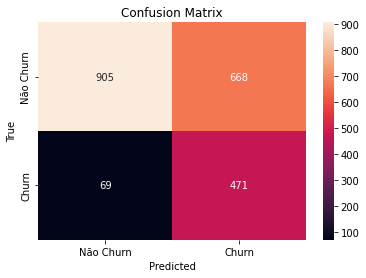

In [ ]:


xgb = XGBClassifier(learning_rate=0.0001, n_estimators=25, max_depth=1, min_child_weight=0.0001, gamma=0)
xgb.fit(X_train_norm_alpha_um, Y_treino)

predict = xgb.predict(X_val_norm_alpha_um)
##fazendo a matriz de confusão
confusion_matrix = sklearn.metrics.confusion_matrix(Y_val, predict)

ax= plt.subplot()
sb.heatmap(confusion_matrix, xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'], annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted');ax.set_ylabel('True');
ax.set_title('Confusion Matrix');



In [ ]:
recall_score(Y_val, predict)

0.8722222222222222

COM 2 VARIÁVEIS

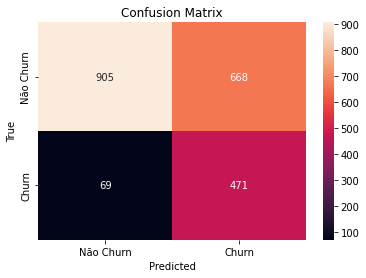

In [ ]:


xgb = XGBClassifier(learning_rate=0.0001, n_estimators=25, max_depth=1, min_child_weight=0.0001, gamma=0)
xgb.fit(X_train_norm_alpha_dois, Y_treino)

predict = xgb.predict(X_val_norm_alpha_dois)
##fazendo a matriz de confusão
confusion_matrix = sklearn.metrics.confusion_matrix(Y_val, predict)

ax= plt.subplot()
sb.heatmap(confusion_matrix, xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'], annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted');ax.set_ylabel('True');
ax.set_title('Confusion Matrix');



validação

In [ ]:
predict = clf.predict(X_val_norm_alpha_dois)
recall_score(Y_val, predict)

0.8037037037037037

Treino

In [ ]:
predict = clf.predict(X_train_norm_alpha_dois)
recall_score(Y_treino, predict)

0.8500416550958068